In [3]:
import datetime
import pandas as pd
import os
import numpy as np
import diptest
from matplotlib import pyplot
#import plotly.express as px
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'

In [4]:
def retrieve_data(path):

    columns = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]',
       'Waste  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'Time']

    # creo il vettore degli anni e il df vuoto dove appendere i singoli df
    years = [2016, 2017, 2018, 2019, 2020, 2021] # , 2022
    tot = pd.DataFrame()
    
    # carico i dati dei diversi anni
    for year in years:
        df = pd.read_csv(os.path.join(path, f"ITA{year}.csv"), parse_dates = ['MTU'])
        #df = df.reset_index()
        
        # aggiusto il formato della data in YYYY-MM-DD HH:mm:ss
        for i, row in df.iterrows():
            df["MTU"][i] = df['MTU'][i][:16]
        
        #df = df.drop_duplicates()
        
        df['Time'] = pd.to_datetime(df['MTU'], utc=True, infer_datetime_format=True)

        df.Time = df.Time.dt.strftime('%Y-%m-%d %H:%M:%S')

        df['Time'] = df['Time'].drop_duplicates()

        df = df[columns].sort_values(by=['Time'])
        
        # appendo i vari df a quello vuoto principale
        tot = pd.concat([tot, df], ignore_index=True)
    
    # imposto la data come indice
    tot = tot.set_index(pd.DatetimeIndex(tot['Time']))

    #tot.sort_index
    
    return tot
data = retrieve_data(path)

C:\Users\loren\AppData\Local\Temp\ipykernel_54288\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_54288\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_54288\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16

In [5]:
print('There are {} missing values or NaNs in df_final.'.format(data.isnull().values.sum()))

data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

There are 2245 missing values or NaNs in df_final.


In [6]:
def data_and_aggregator(df):

    # seleziono tutte le colonne delle fonti energetiche
    columns = df.columns[ : df.shape[1]-1]

    # aggrego giornalmente i dati
    #daily_df = pd.DataFrame(df[columns].groupby([pd.Grouper(level='Time', freq='D')]).sum())

    # creo l'aggregato totale
    df['total_aggregated'] = df[columns].sum(axis=1)

    # aggrego i dati dell'idroelettrico
    hydro_cols = ['Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]']
    
    df['hydro_tot'] = df[hydro_cols].sum(axis=1)

    # aggrego i dati del gas
    gas_cols = ['Fossil Coal-derived gas  - Actual Aggregated [MW]',
                'Fossil Gas  - Actual Aggregated [MW]']
    
    df['gas_tot'] = df[gas_cols].sum(axis=1)

    df = df.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'hard_coal', 
                            'Fossil Oil  - Actual Aggregated [MW]': 'oil',
                            'Geothermal  - Actual Aggregated [MW]': 'geothermal',
                            'Waste  - Actual Aggregated [MW]': 'waste',
                            'Other  - Actual Aggregated [MW]': 'other',
                            'Solar  - Actual Aggregated [MW]' : 'solar',
                            'Wind Onshore  - Actual Aggregated [MW]' : 'wind',
                            'Biomass  - Actual Aggregated [MW]' : 'biomass'})
    
    df = df.drop(df[hydro_cols], axis = 1)
    df = df.drop(df[gas_cols], axis = 1)

    return df
data = data_and_aggregator(data)

In [7]:
# creo due dunzioni: una per i weekend (quando sabato/domenica è 1, altrimenti 0) e l'altra per le vacanze (1/1, 25/4, 1/5, 2/6, 15/8, 25/12)
def businesshour_and_we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        hour = position.hour
        weekend = position.weekday()
        month = position.month
        df.loc[position, 'weekend'] = weekend
        df.loc[position, 'hour'] = hour
        
        if (weekend == 5):
            df.loc[position, 'saturday'] = 1
            df.loc[position, 'weekend'] = 1
        elif (weekend == 6):
            df.loc[position, 'sunday'] = 1
            df.loc[position, 'weekend'] = 2
        else:
            df.loc[position, 'saturday'] = 0
            df.loc[position, 'sunday'] = 0
            df.loc[position, 'weekend'] = 0
            
        if (hour >= 8 and hour <= 18):
            df.loc[position, 'business hour'] = 1
        else:
            df.loc[position, 'business hour'] = 0

    df.saturday = df.saturday.fillna(0)
    df.sunday = df.sunday.fillna(0)

    return df

data = businesshour_and_we_generation(data)
data = data.dropna()

In [8]:
## Get all unique years in the dataset
#years = data.index.year.unique()
#
## Iterate through each year
#for year in years:
#    # Filter data for the current year
#    year_data = data[data.index.year == year]
#    
#    # Separate weekend and weekday data
#    weekend_data = year_data[(year_data['weekend'] == 1) | (year_data['weekend'] == 2)]
#    weekday_data = year_data[year_data['weekend'] == 0]
#    
#    # Calculate average hourly values for weekends and weekdays
#    avg_hourly_data_weekend = weekend_data.groupby(weekend_data.index.hour).mean()
#    avg_hourly_data_weekday = weekday_data.groupby(weekday_data.index.hour).mean()
#    
#    # Generate plots for weekends and weekdays
#    for avg_data, day_type in zip([avg_hourly_data_weekend, avg_hourly_data_weekday], ['Weekend', 'Weekday']):
#        plt.figure(figsize=(15, 10))
#        for column in avg_data.columns:
#            if column not in ['weekend', 'hour', 'saturday', 'sunday', 'business hour']:
#                plt.plot(avg_data.index, avg_data[column], label=column)
#
#        plt.xlabel('Hour of the Day')
#        plt.ylabel('Average Power Generated (MW)')
#        plt.title(f'Average Power Generated by Hour for Different Energy Sources ({year}, {day_type})')
#        plt.legend()
#        plt.grid(True)
#        plt.show()

In [9]:
## Get all unique years in the dataset
#years = data.index.year.unique()
#
## Define energy sources
#energy_sources = [column for column in data.columns if column not in ['weekend', 'hour', 'saturday', 'sunday', 'business hour']]
#
## Iterate through each year
#for year in years:
#    # Filter data for the current year
#    year_data = data[data.index.year == year]
#    
#    # Separate weekend and weekday data
#    weekend_data = year_data[(year_data['weekend'] == 1) | (year_data['weekend'] == 2)]
#    weekday_data = year_data[year_data['weekend'] == 0]
#    
#    # Calculate average hourly values for weekends and weekdays
#    avg_hourly_data_weekend = weekend_data.groupby(weekend_data.index.hour)[energy_sources].mean()
#    avg_hourly_data_weekday = weekday_data.groupby(weekday_data.index.hour)[energy_sources].mean()
#    
#    # Generate boxplots for weekends and weekdays
#    for avg_data, day_type in zip([avg_hourly_data_weekend, avg_hourly_data_weekday], ['Weekend', 'Weekday']):
#        avg_data.boxplot(figsize=(15, 10), vert=False)
#        plt.xlabel('Average Power Generated (MW)')
#        plt.title(f'Boxplot of Average Power Generated by Hour for Different Energy Sources ({year}, {day_type})')
#        plt.grid(True)
#        plt.show()

In [10]:
## Get all unique years in the dataset
#years = data.index.year.unique()
#
## Define energy source as 'total_aggregated'
#energy_source = ['total_aggregated']
#
## Iterate through each year
#for year in years:
#    # Filter data for the current year
#    year_data = data[data.index.year == year]
#    
#    # Separate weekend and weekday data
#    weekend_data = year_data[(year_data['weekend'] == 1) | (year_data['weekend'] == 2)]
#    weekday_data = year_data[year_data['weekend'] == 0]
#    
#    # Calculate average hourly values for weekends and weekdays
#    avg_hourly_data_weekend = weekend_data.groupby(weekend_data.index.hour)[energy_source].mean()
#    avg_hourly_data_weekday = weekday_data.groupby(weekday_data.index.hour)[energy_source].mean()
#
#    # Create a figure and a set of subplots
#    fig, axs = plt.subplots(1, 2, figsize=(15,8))
#
#    # Line plot for average hourly data
#    axs[0].plot(avg_hourly_data_weekend.index, avg_hourly_data_weekend[energy_source], color='blue', label='Weekend')
#    axs[0].plot(avg_hourly_data_weekday.index, avg_hourly_data_weekday[energy_source], color='orange', label='Weekday')
#    axs[0].set_xlabel('Hour of the Day')
#    axs[0].set_ylabel('Average Power Generated (MW)')
#    axs[0].set_title(f'Average Power Generated by Hour ({year})')
#    axs[0].legend()
#    axs[0].grid(True)
#
#    # Boxplot for average hourly data (Vertical boxplot)
#    avg_hourly_data_weekend.boxplot(ax=axs[1], color=dict(boxes='blue', whiskers='blue', medians='blue', caps='blue'), boxprops=dict(linestyle='-', linewidth=1.5), medianprops=dict(linestyle='-', linewidth=1.5), whiskerprops=dict(linestyle='-', linewidth=1.5), capprops=dict(linestyle='-', linewidth=1.5), flierprops=dict(marker='o', markersize=5, markerfacecolor='blue'), positions=[1], widths = 0.6, vert=True)
#    avg_hourly_data_weekday.boxplot(ax=axs[1], color=dict(boxes='orange', whiskers='orange', medians='orange', caps='orange'), boxprops=dict(linestyle='-', linewidth=1.5), medianprops=dict(linestyle='-', linewidth=1.5), whiskerprops=dict(linestyle='-', linewidth=1.5), capprops=dict(linestyle='-', linewidth=1.5), flierprops=dict(marker='o', markersize=5, markerfacecolor='orange'), positions=[2], widths = 0.6, vert=True)
#    axs[1].set_xticks([1, 2])
#    axs[1].set_xticklabels(['Weekend', 'Weekday'])
#    axs[1].set_ylabel('Average Power Generated (MW)')
#    axs[1].set_title(f'Boxplot of Average Power Generated by Hour ({year})')
#    axs[1].grid(True)
#
#    # Display the figure
#    plt.tight_layout()
#    plt.show()
#

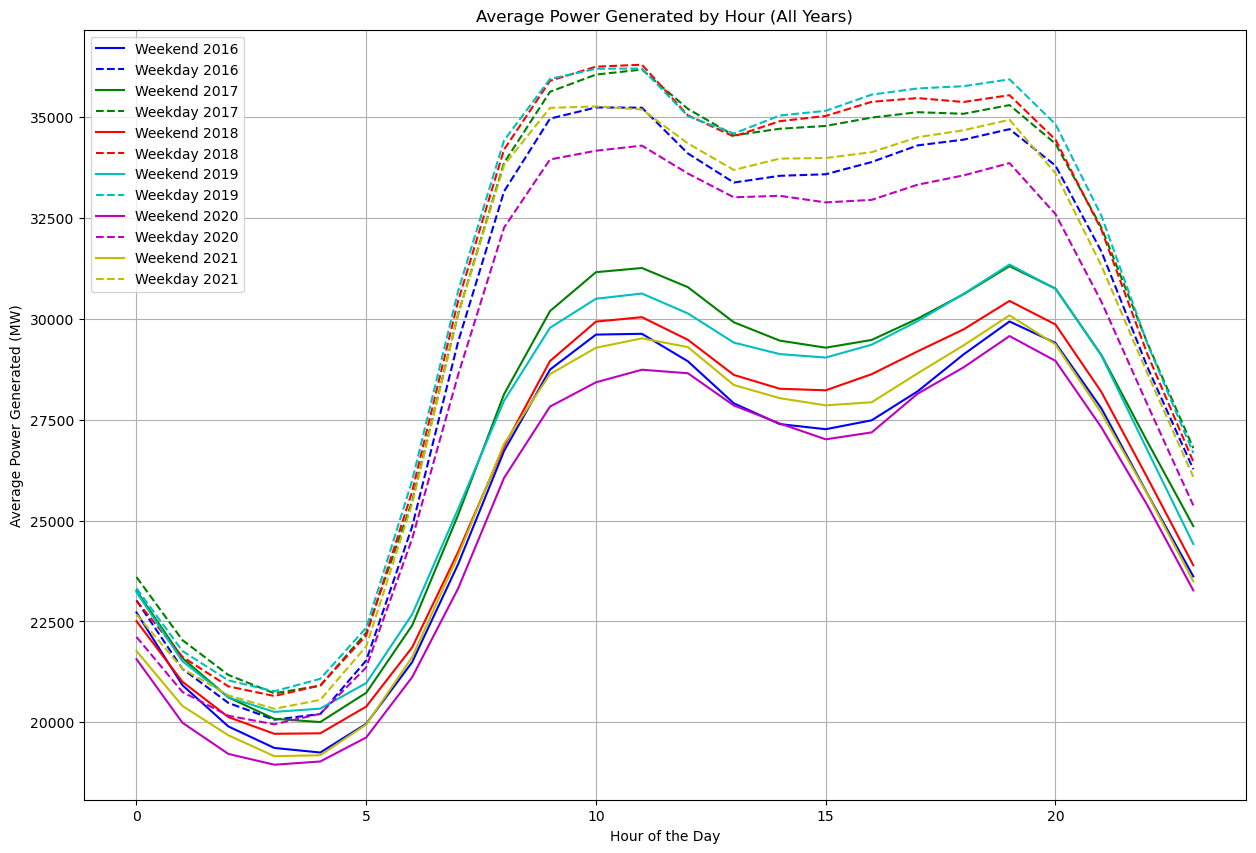

In [11]:
# Get all unique years in the dataset
years = data.index.year.unique()

# Define energy source as 'total_aggregated'
energy_source = ['total_aggregated']

# Define colors for each year
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Initialize plot
fig, ax = plt.subplots(figsize=(15, 10))

# Iterate through each year
for idx, year in enumerate(years):
    # Filter data for the current year
    year_data = data[data.index.year == year]
    
    # Separate weekend and weekday data
    weekend_data = year_data[(year_data['weekend'] == 1) | (year_data['weekend'] == 2)]
    weekday_data = year_data[year_data['weekend'] == 0]
    
    # Calculate average hourly values for weekends and weekdays
    avg_hourly_data_weekend = weekend_data.groupby(weekend_data.index.hour)[energy_source].mean()
    avg_hourly_data_weekday = weekday_data.groupby(weekday_data.index.hour)[energy_source].mean()

    # Add lines to the plot for each year
    ax.plot(avg_hourly_data_weekend.index, avg_hourly_data_weekend[energy_source], label=f'Weekend {year}', color=colors[idx % len(colors)])
    ax.plot(avg_hourly_data_weekday.index, avg_hourly_data_weekday[energy_source], label=f'Weekday {year}', color=colors[idx % len(colors)], linestyle='--')

# Set plot parameters and show the plot
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Average Power Generated (MW)')
ax.set_title('Average Power Generated by Hour (All Years)')
ax.legend()
ax.grid(True)
plt.show()

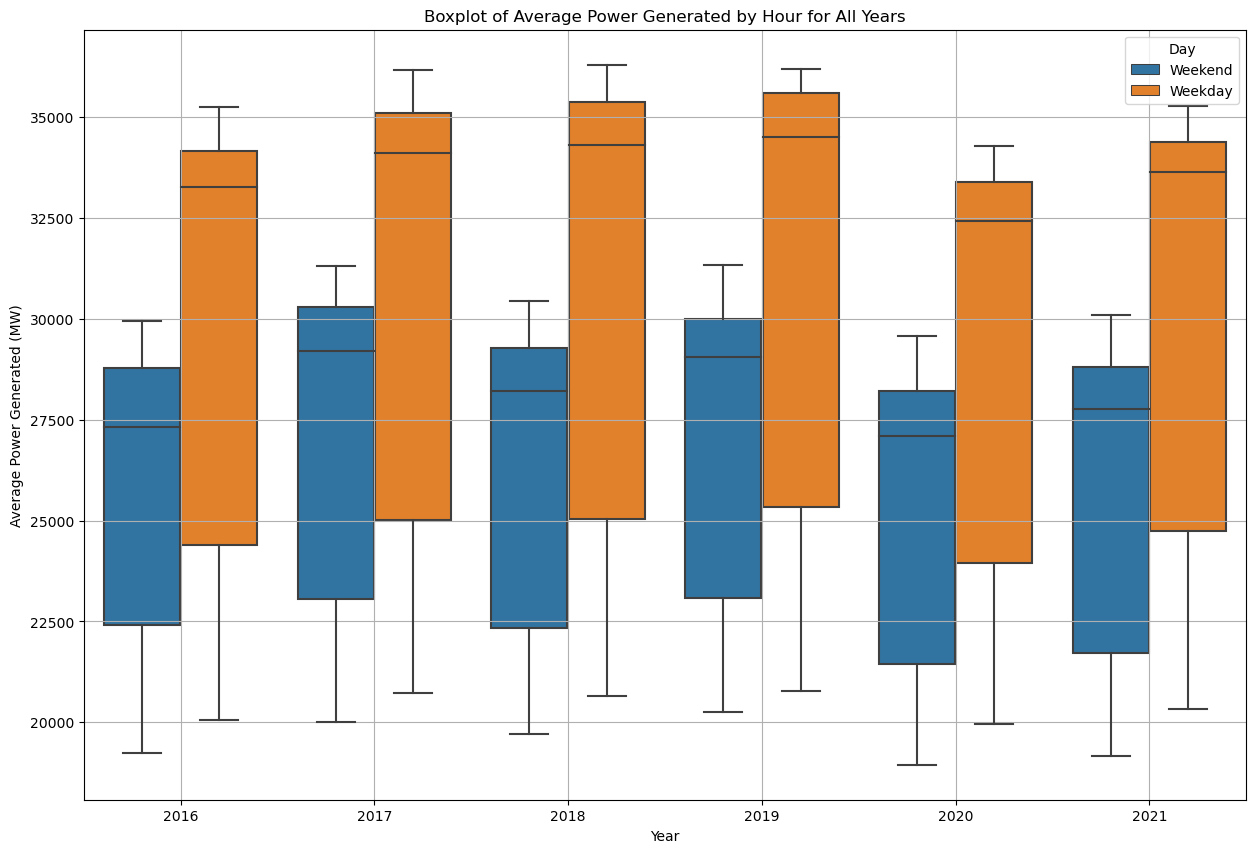

In [12]:
# Define energy source as 'total_aggregated'
energy_source = 'total_aggregated'

# Create an empty DataFrame to store combined data
combined_data = pd.DataFrame()

# Iterate through each year
for year in years:
    # Filter data for the current year
    year_data = data[data.index.year == year]
    
    # Separate weekend and weekday data
    weekend_data = year_data[(year_data['weekend'] == 1) | (year_data['weekend'] == 2)]
    weekday_data = year_data[year_data['weekend'] == 0]
    
    # Calculate average hourly values for weekends and weekdays
    avg_hourly_data_weekend = weekend_data.groupby(weekend_data.index.hour)[energy_source].mean().to_frame().assign(Day='Weekend', Year=year)
    avg_hourly_data_weekday = weekday_data.groupby(weekday_data.index.hour)[energy_source].mean().to_frame().assign(Day='Weekday', Year=year)
    
    # Concatenate data from this year to the combined data
    combined_data = pd.concat([combined_data, avg_hourly_data_weekend, avg_hourly_data_weekday], axis=0)

# Create boxplot
plt.figure(figsize=(15,10))
sns.boxplot(data=combined_data, x='Year', y=energy_source, hue='Day')

plt.title('Boxplot of Average Power Generated by Hour for All Years')
plt.xlabel('Year')
plt.ylabel('Average Power Generated (MW)')
plt.grid(True)
plt.show()


In [13]:
data['total_aggregated'].describe()

count    52608.000000
mean     28876.534595
std       7084.385417
min      13312.600000
25%      22955.750000
50%      28256.000000
75%      34688.250000
max      50223.588235
Name: total_aggregated, dtype: float64

In [14]:
rolling1 = data['total_aggregated'].rolling(24, center=True).mean()
rolling2 = data['total_aggregated'].rolling(24 * 2, center=True).mean()
rolling3 = data['total_aggregated'].rolling(24 * 7, center=True).mean()
rolling4 = data['total_aggregated'].rolling(24 * 12, center=True).mean()
rolling5 = data['total_aggregated'].rolling(24 * 365, center=True).mean()

In [15]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

C:\Users\loren\AppData\Local\Temp\ipykernel_54288\555801525.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def plot_series(df=None, column=None, series=pd.Series([]),


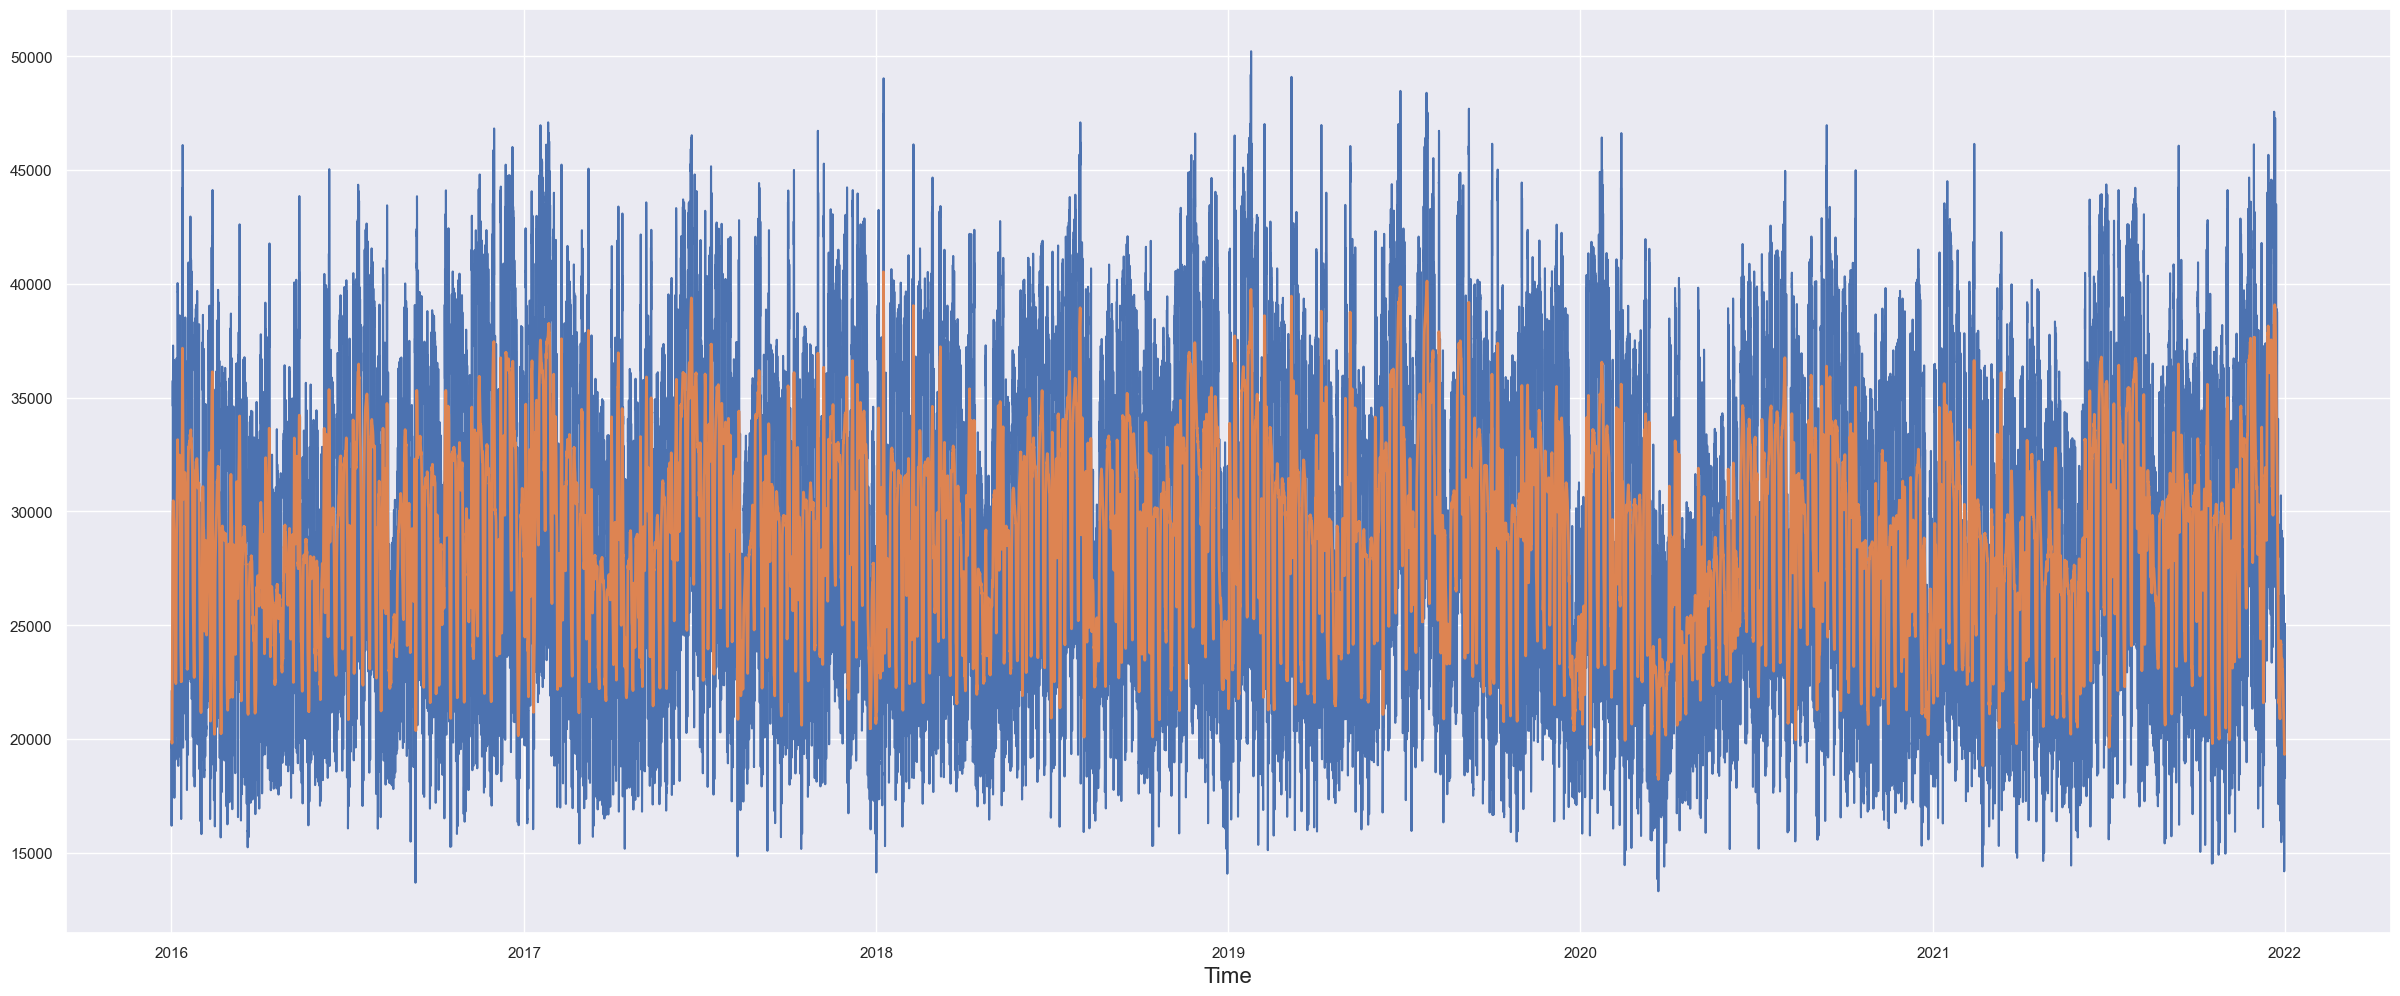

In [16]:
ax = plot_series(data, 'total_aggregated')
ax.plot(rolling1, linestyle='-', linewidth=2, label='Daily rolling mean')

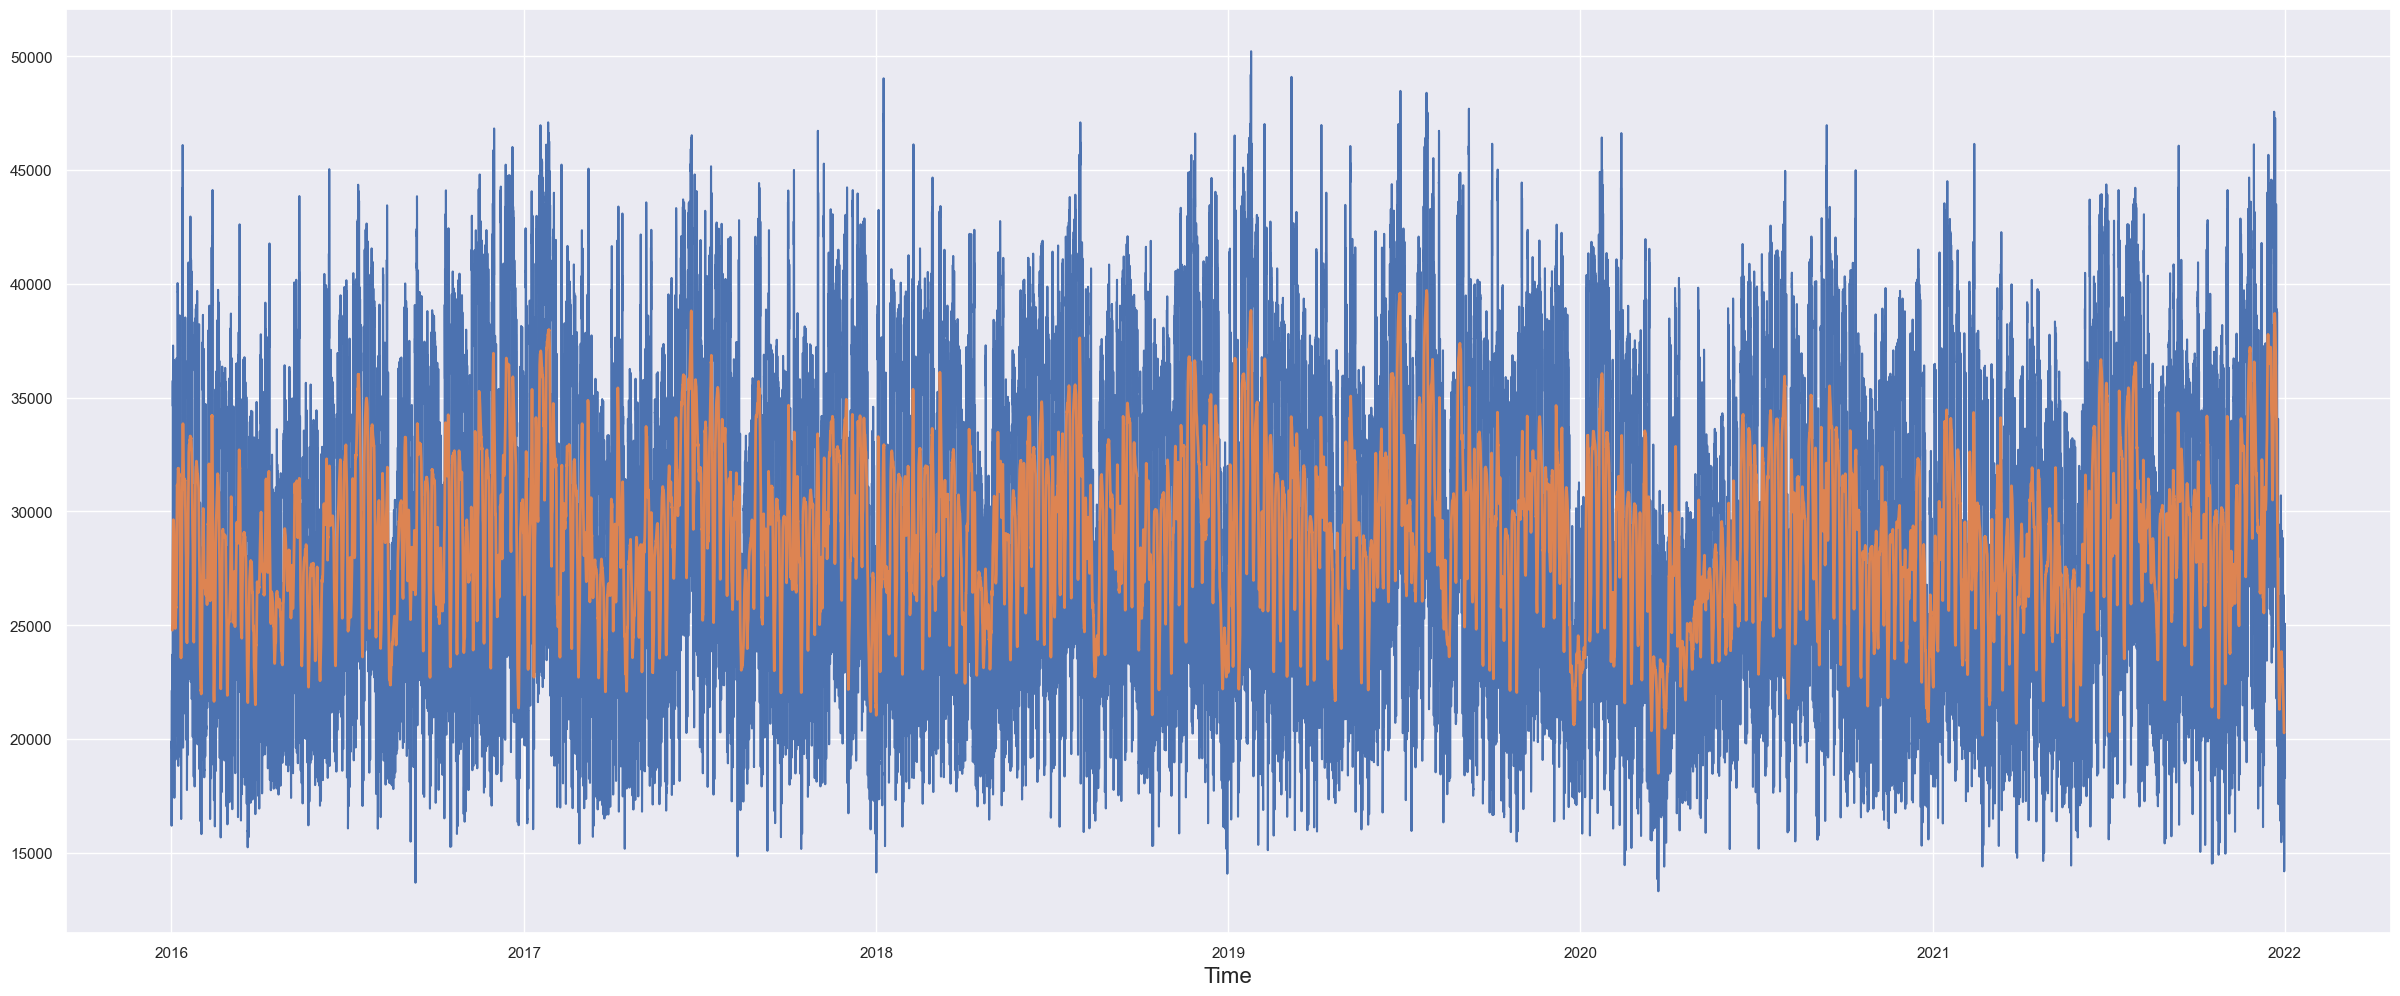

In [17]:
ax = plot_series(data, 'total_aggregated')
ax.plot(rolling2, linestyle='-', linewidth=2, label='48h rolling mean')

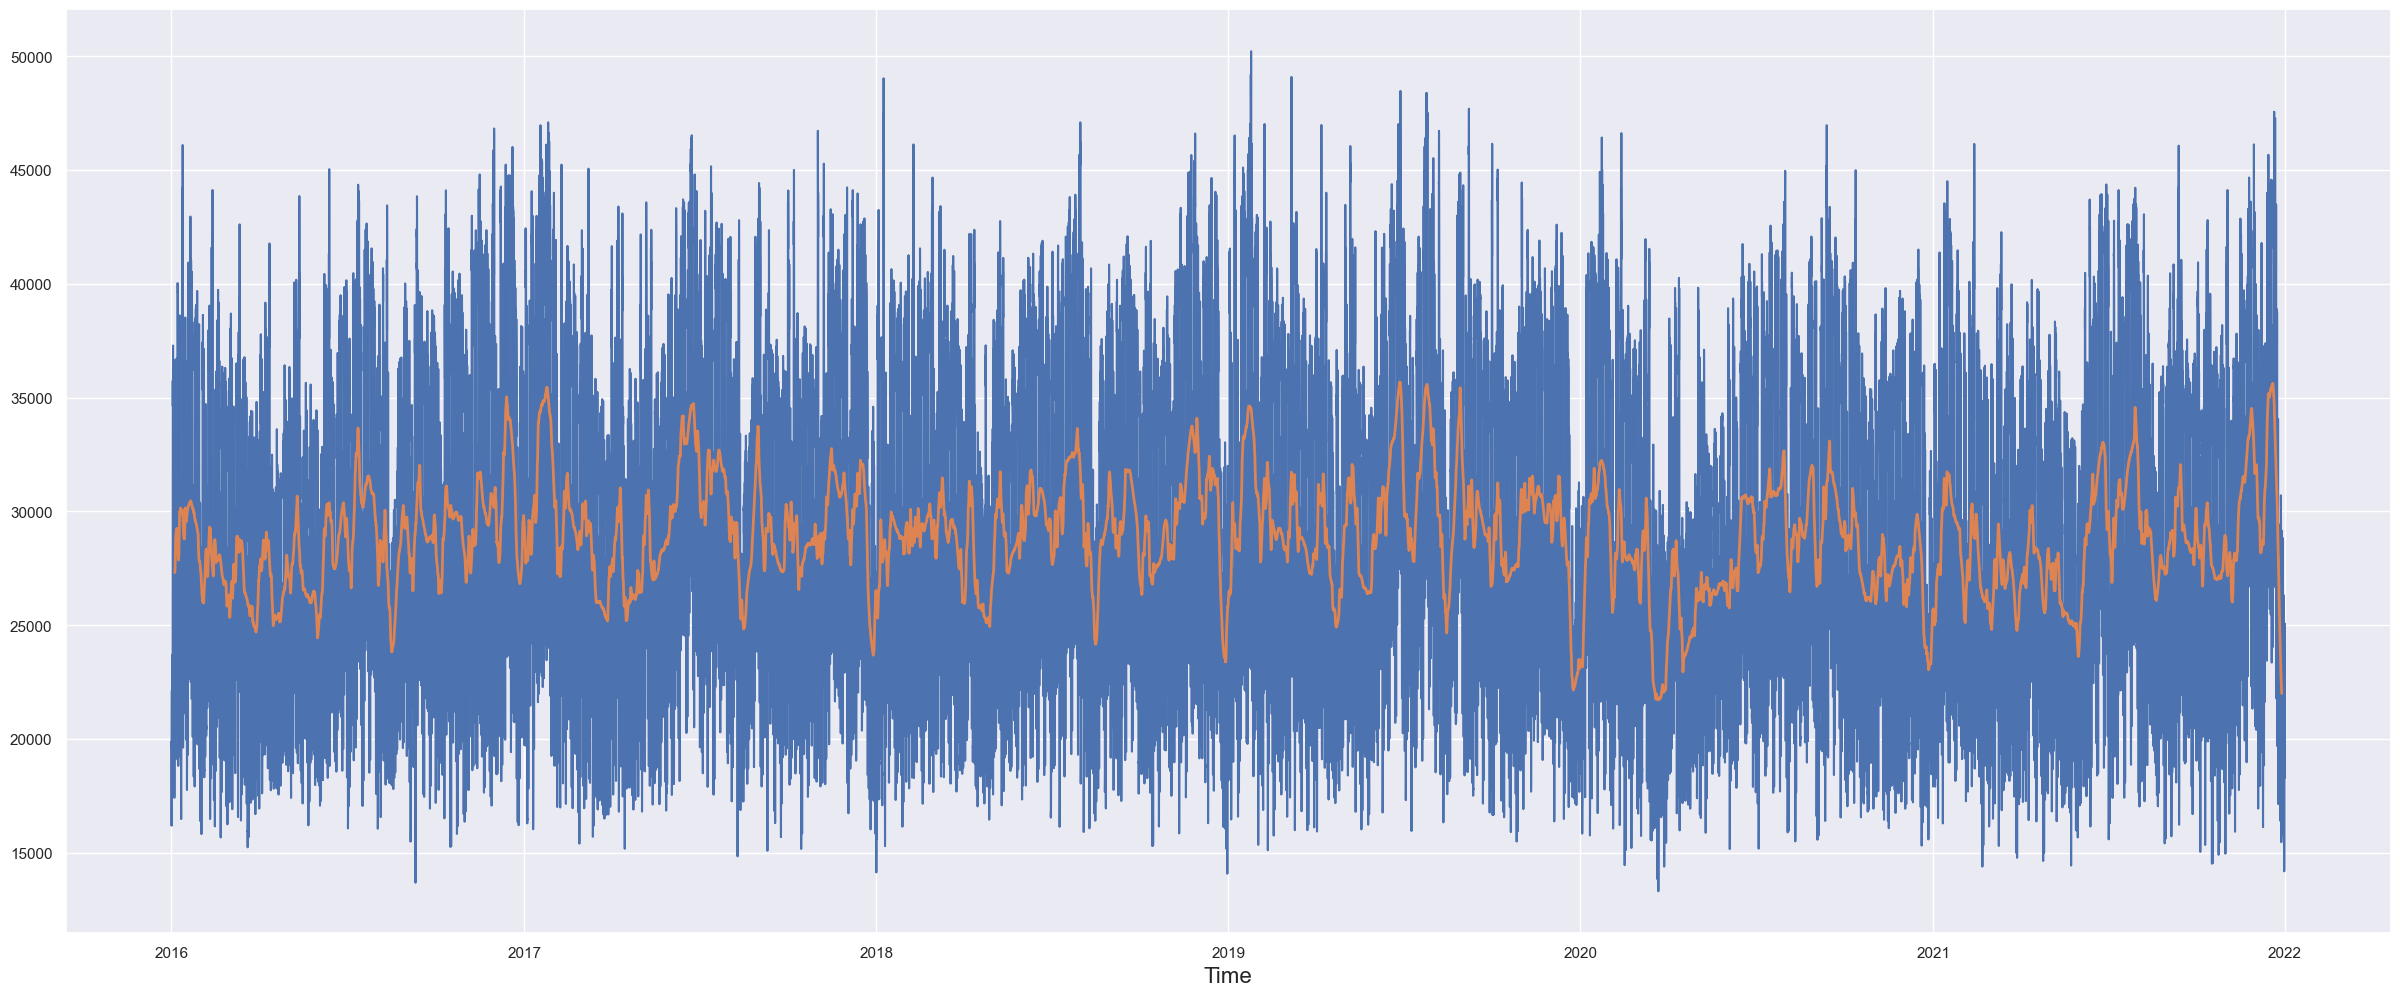

In [18]:
ax = plot_series(data, 'total_aggregated')
ax.plot(rolling3, linestyle='-', linewidth=2, label='Weekly rolling mean')

In [33]:
#ax = plot_series(data, 'total_aggregated')
#ax.plot(rolling4, linestyle='-', linewidth=2, label='Monthly rolling mean')

In [23]:
#ax = plot_series(data, 'total_aggregated')
#ax.plot(rolling5, linestyle='-', linewidth=2, label='Yearly rolling mean')

In [24]:
energies = ['total_aggregated','biomass', 'hard_coal', 'oil', 'geothermal', 'other', 'solar', 'waste',
       'wind', 'hydro_tot', 'gas_tot']

In [26]:
dip, pval = diptest.diptest(data['total_aggregated'])
print("Hartigan's dip test for unimodality")
print("Statistic:", dip)
print("P-value:", pval)

Hartigan's dip test for unimodality
Statistic: 0.005419094256871929
P-value: 0.0


Total Aggregated energy distribution plot


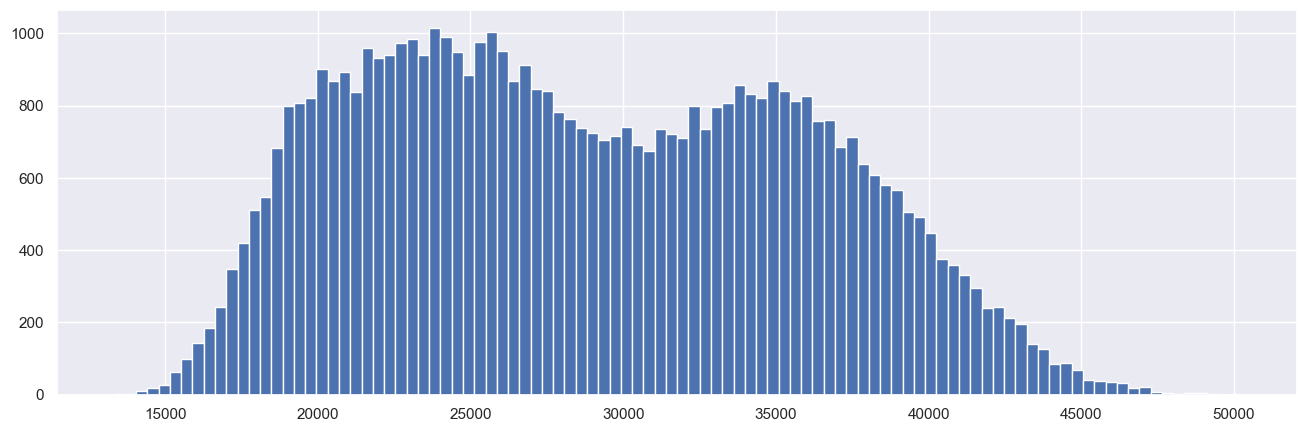

In [27]:
plt.figure(figsize=(16,5))
plt.hist(data['total_aggregated'], bins=100)
print('Total Aggregated energy distribution plot')
plt.show()

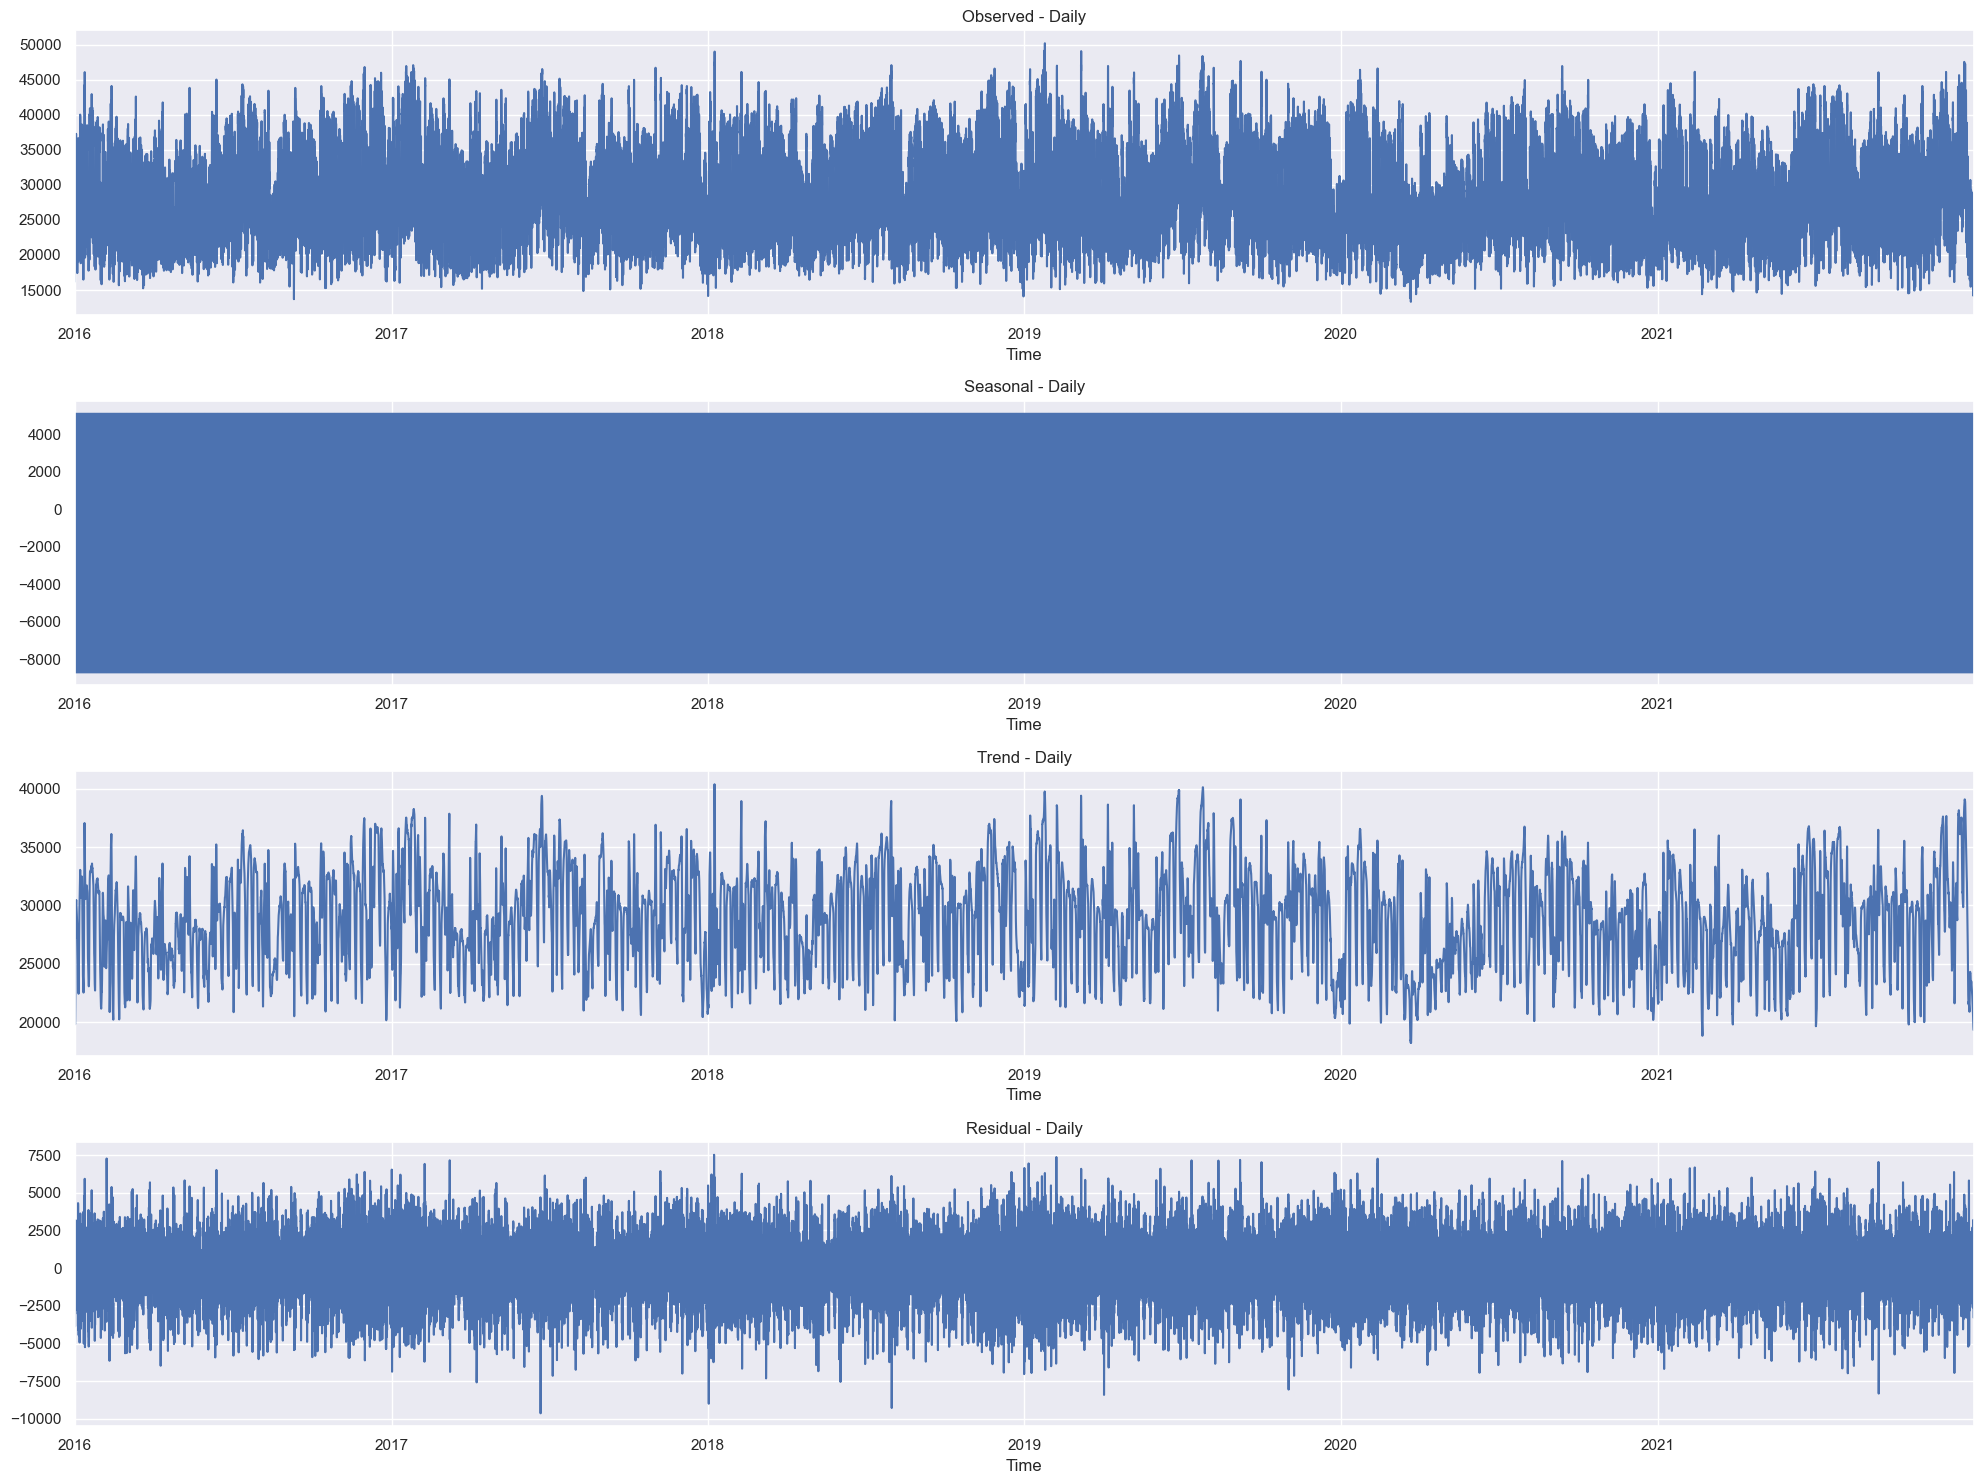

In [28]:
res1 = sm.tsa.seasonal_decompose(data['total_aggregated'], model='additive', period=24)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 15))
res1.observed.plot(ax=ax1, title='Observed - Daily')
res1.seasonal.plot(ax=ax2, title='Seasonal - Daily')
res1.trend.plot(ax=ax3, title='Trend - Daily')
res1.resid.plot(ax=ax4, title='Residual - Daily')
plt.tight_layout()
plt.show()

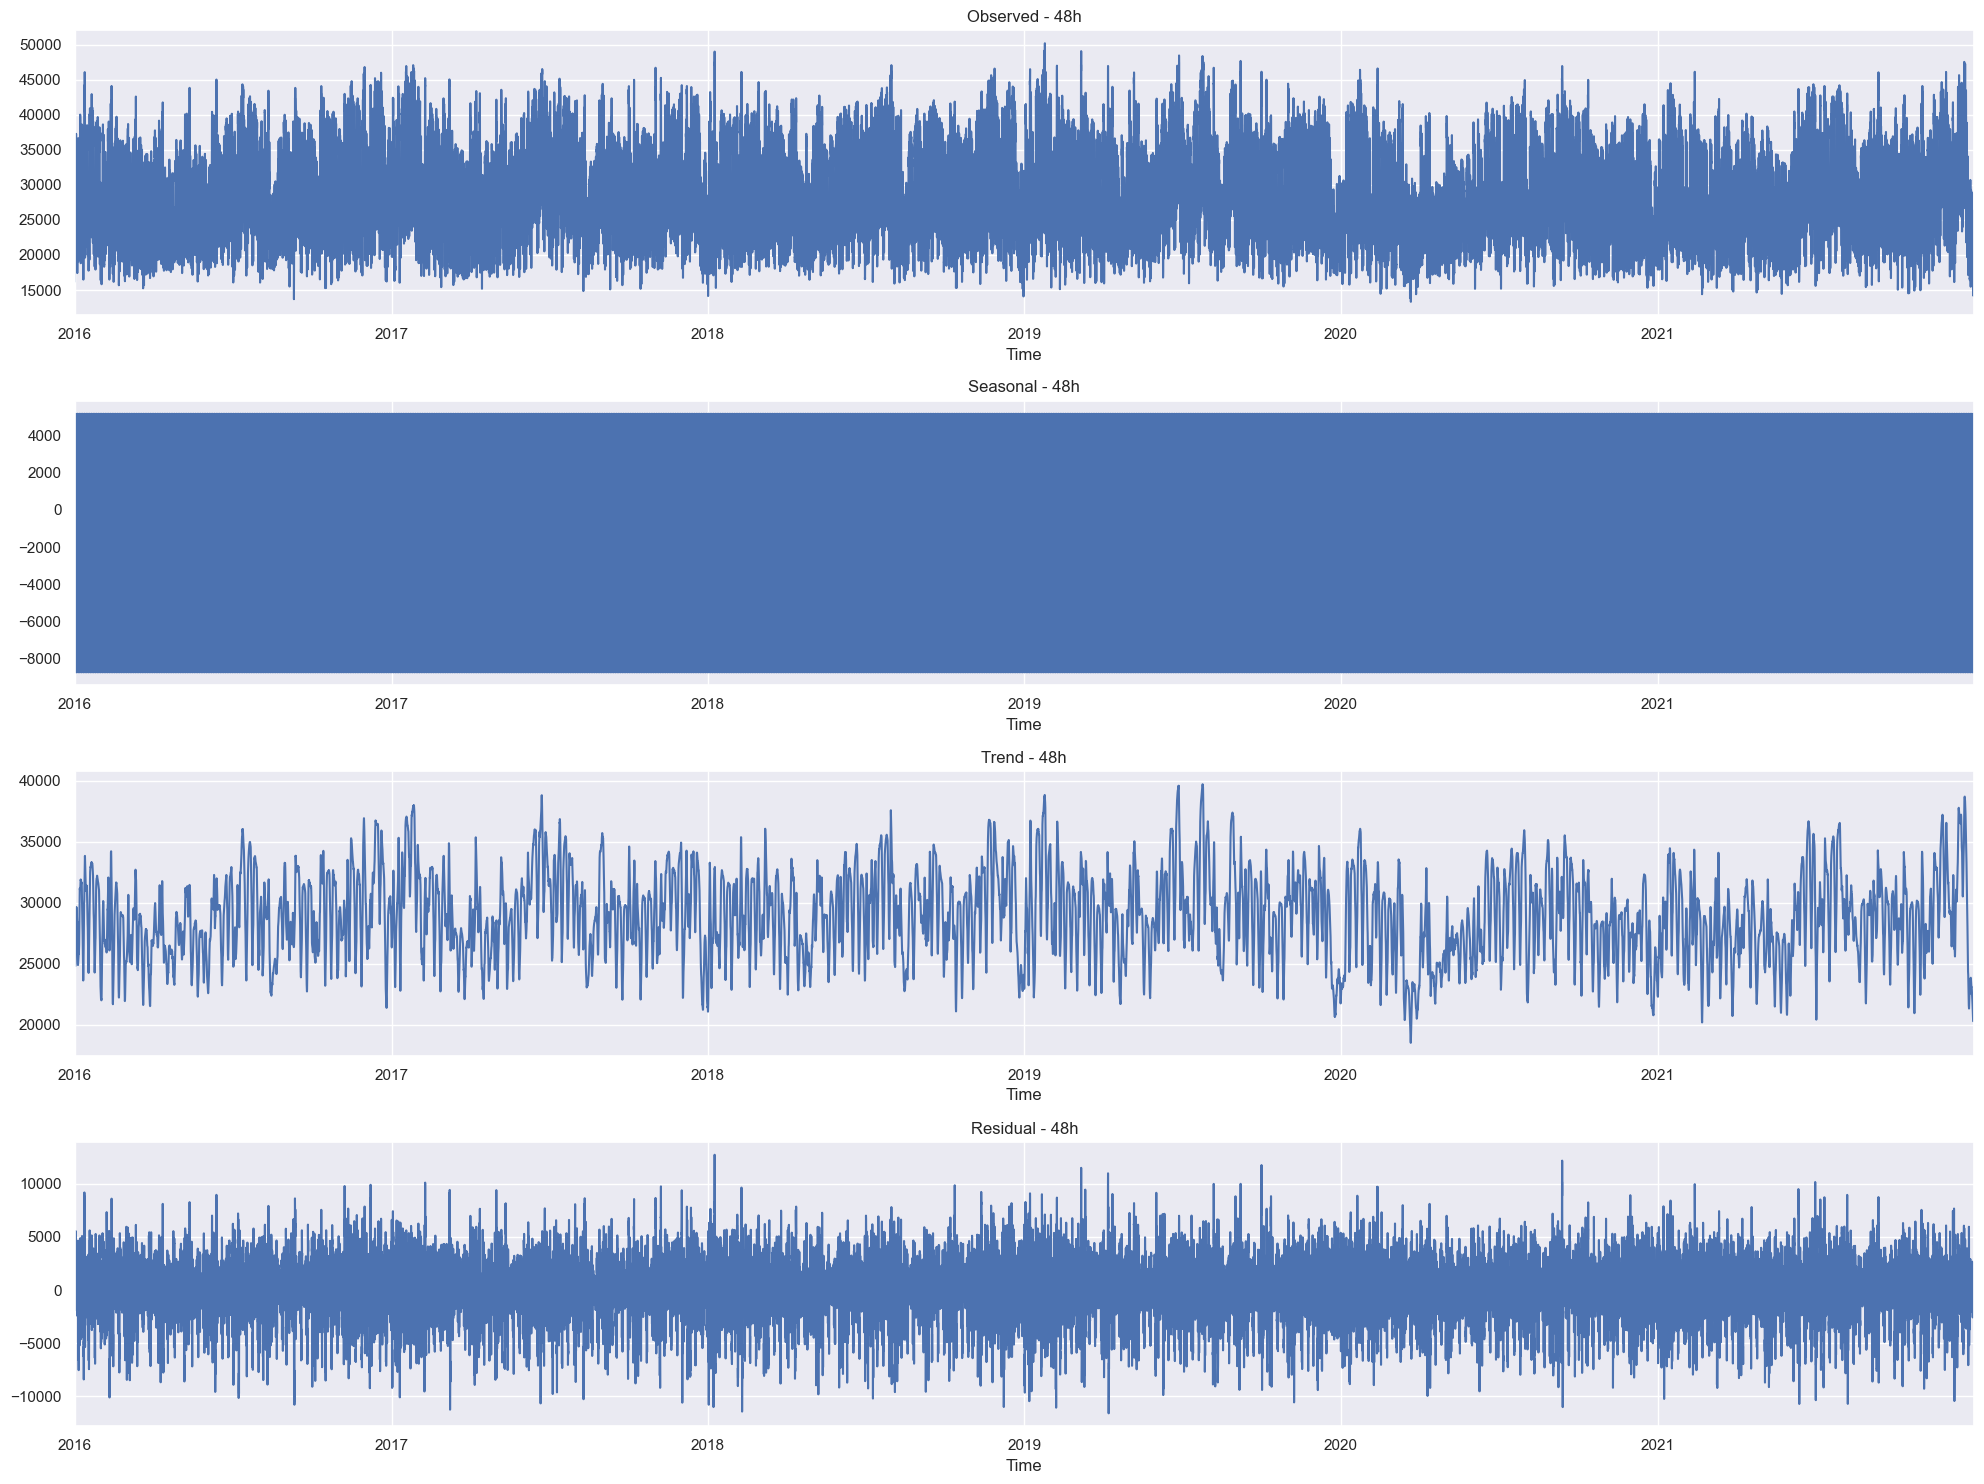

In [29]:
res2 = sm.tsa.seasonal_decompose(data['total_aggregated'], model='additive', period=24*2)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 15))
res2.observed.plot(ax=ax1, title='Observed - 48h')
res2.seasonal.plot(ax=ax2, title='Seasonal - 48h')
res2.trend.plot(ax=ax3, title='Trend - 48h')
res2.resid.plot(ax=ax4, title='Residual - 48h')
plt.tight_layout()
plt.show()

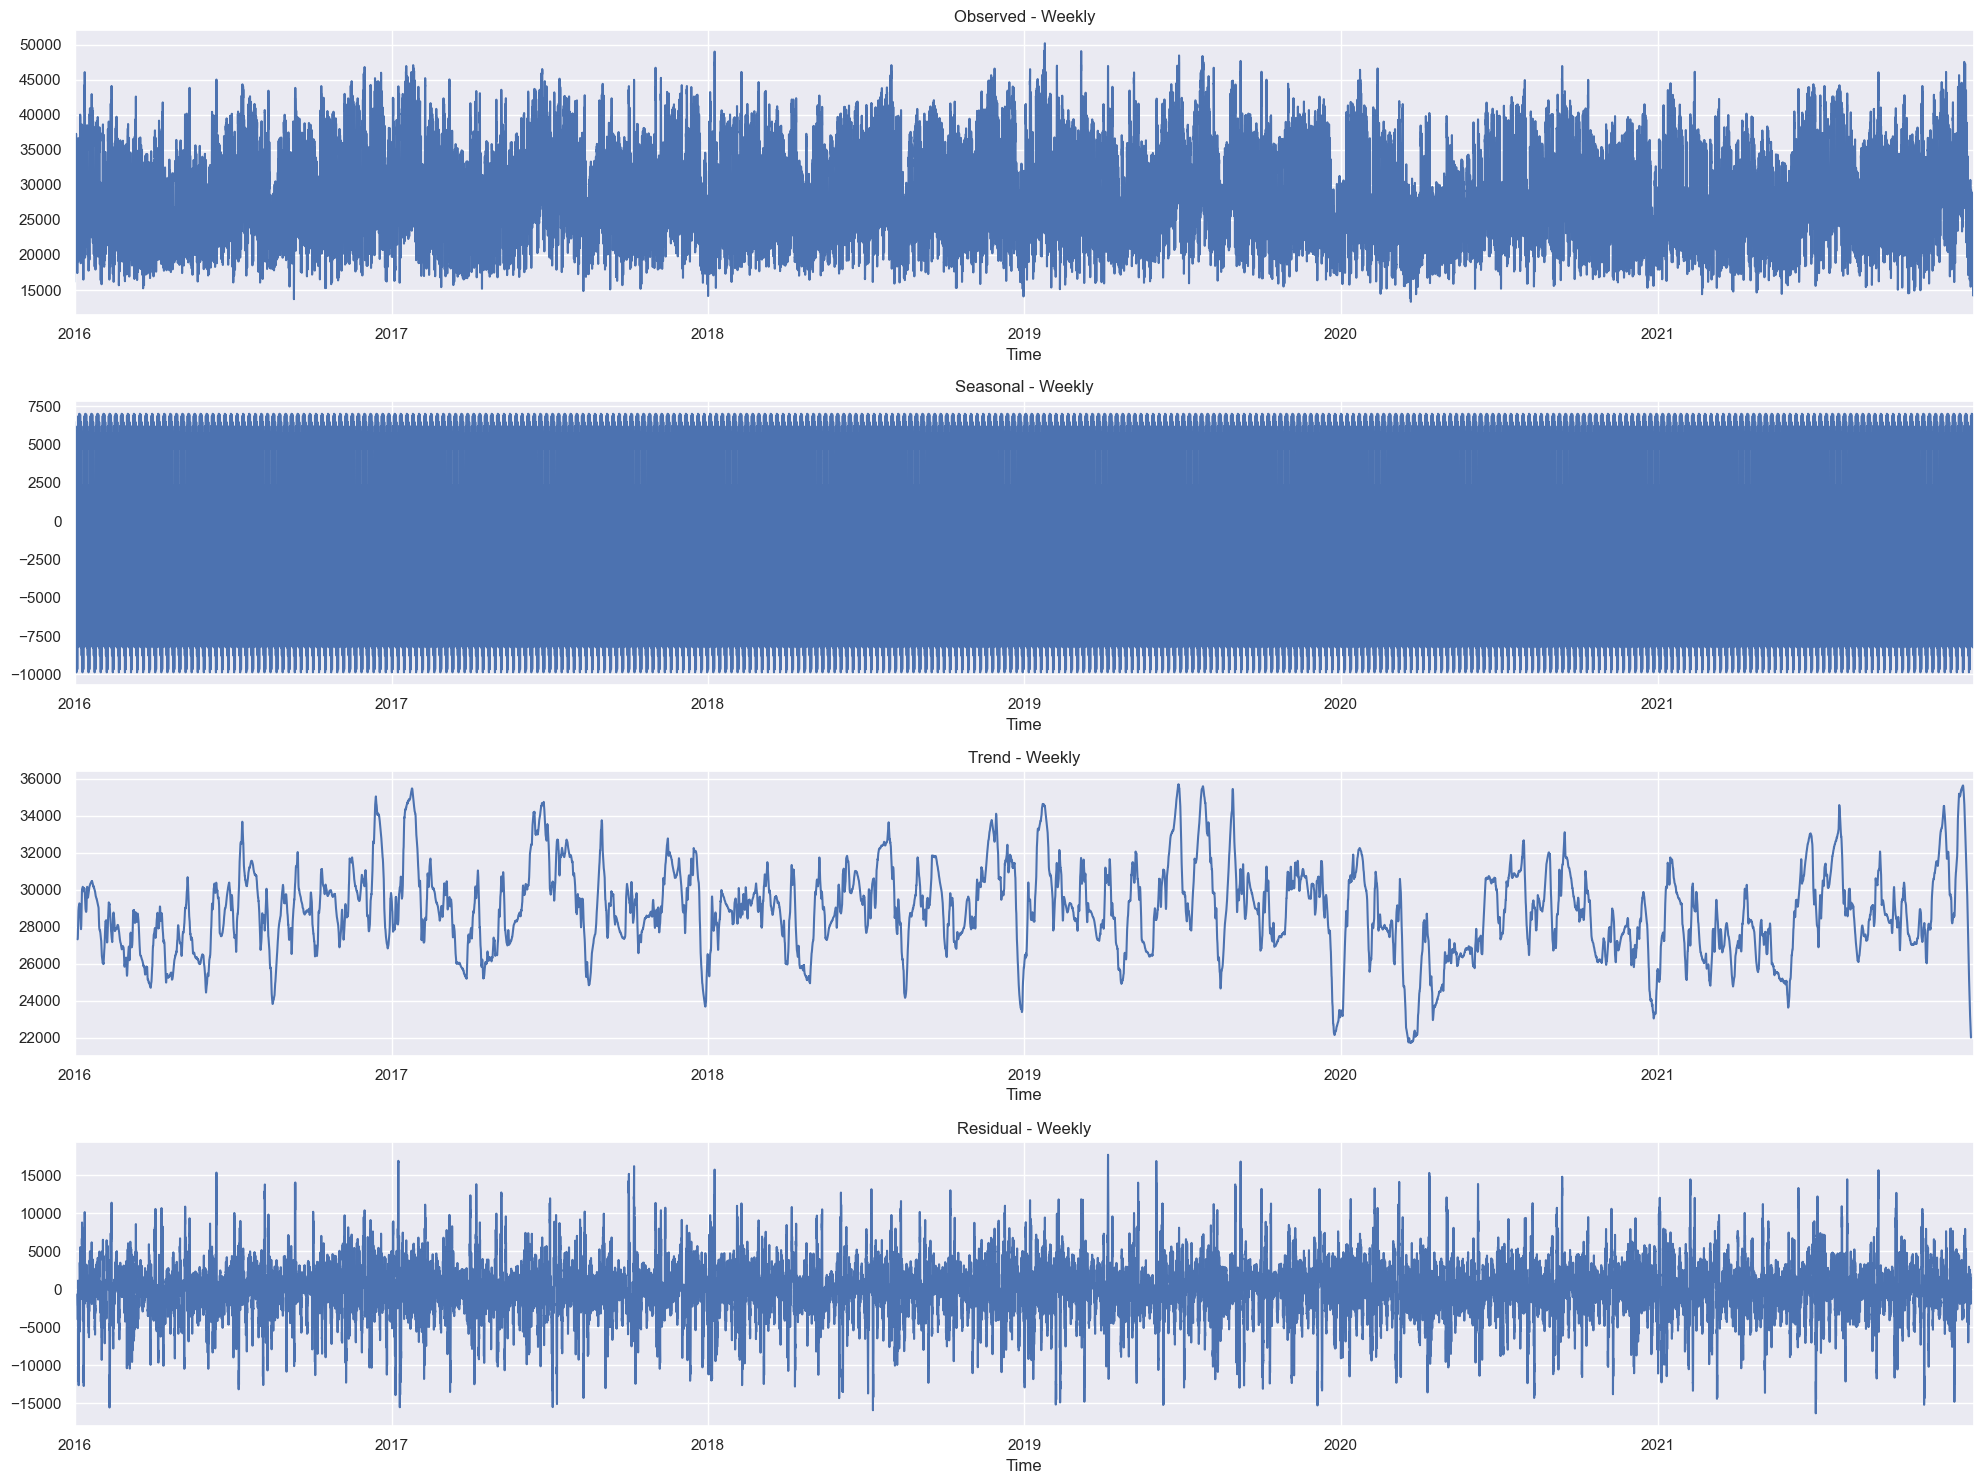

In [30]:
res3 = sm.tsa.seasonal_decompose(data['total_aggregated'], model='additive', period=24*7)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 15))
res3.observed.plot(ax=ax1, title='Observed - Weekly')
res3.seasonal.plot(ax=ax2, title='Seasonal - Weekly')
res3.trend.plot(ax=ax3, title='Trend - Weekly')
res3.resid.plot(ax=ax4, title='Residual - Weekly')
plt.tight_layout()
plt.show()

In [32]:
#res4 = sm.tsa.seasonal_decompose(data['total_aggregated'], model='additive', period=24*12)
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 15))
#res4.observed.plot(ax=ax1, title='Observed - Monthly')
#res4.seasonal.plot(ax=ax2, title='Seasonal - Monthly')
#res4.trend.plot(ax=ax3, title='Trend - Monthly')
#res4.resid.plot(ax=ax4, title='Residual - Monthly')
#plt.tight_layout()
#plt.show()

In [31]:
#res5 = sm.tsa.seasonal_decompose(data['total_aggregated'], model='additive', period=24*365)
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 15))
#res5.observed.plot(ax=ax1, title='Observed - Yearly')
#res5.seasonal.plot(ax=ax2, title='Seasonal - Yearly')
#res5.trend.plot(ax=ax3, title='Trend - Yearly')
#res5.resid.plot(ax=ax4, title='Residual - Yearly')
#plt.tight_layout()
#plt.show()

c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


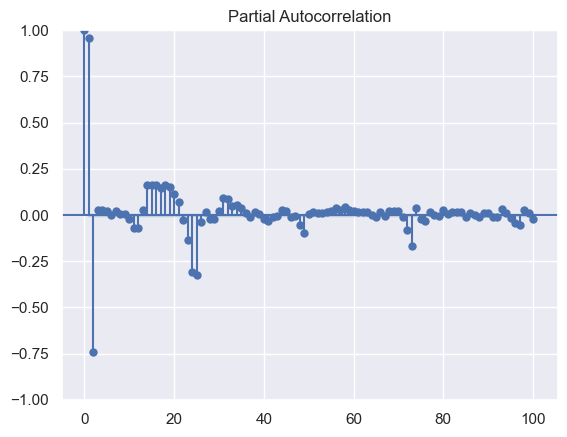

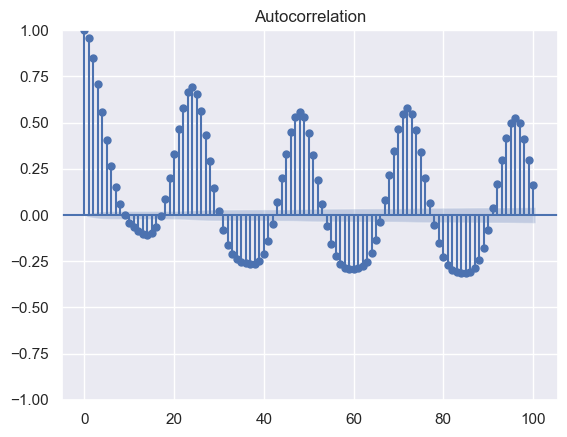

In [34]:
# Ora trovare l'ordine del nostro AR
# Plotto il grafico delle autocorrelazioni per determinare
# quando decade la dipendenza col passato
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(data['total_aggregated'], lags=100)

acf = plot_acf(data['total_aggregated'], lags=100)


In [ ]:
## Facciamo test di stazionarietà classico col DF
#df_stationarityTest = adfuller(data['total_aggregated'])
#
## Check del p-value: è decisamente sotto 0.05, quindi la serie è stazionaria, no unit root
#print('ADF Statistic: %f' % df_stationarityTest[0])
#print('p-value: %f' % df_stationarityTest[1])
#print('Critical Values:')
#for key, value in df_stationarityTest[4].items():
#  print('\t%s: %.3f' % (key, value))

ADF Statistic: -20.859049
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [ ]:
#from scipy.stats import shapiro
#st = shapiro(data['total_aggregated'])
#print('Shapiro-Wilk test results')
#print('Statistic:', st[0])
#print('P-value:', st[1])

Shapiro-Wilk test results
Statistic: 0.9726518988609314
P-value: 0.0


c:\Users\loren\anaconda3\envs\datadesc\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
